<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Module1A_Retail_Demand_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Retail analytics - Predictive Model Training
---
*Yossiri Adulyasak*

---

## Module 1A: Retail predictive model pipeline for multiple items

This is the full version of the Module 1 (predictive model) for session 8 which extend the simplified version of one item to multiple items.

We begin by loading the required packages.

In [1]:
import pandas as pd  # Library for data manipulation (DataFrames)
import numpy as np   # Library for numerical operations (needed for square roots, etc.)

# Import specific machine learning models
import xgboost as xgb        # XGBoost: Optimized Gradient Boosting library
import lightgbm as lgb       # LightGBM: Another high-performance Gradient Boosting library
from sklearn.linear_model import LinearRegression  # Basic Linear Regression
from sklearn.ensemble import RandomForestRegressor # Random Forest (ensemble of trees)

# Import metrics to measure how "wrong" our predictions are
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error



## *Custom function - Error calculations

First, we create a function to measure the quality of predictions

In [2]:
def evaluate_model(model_name, y_true, y_pred):
    # MAE: Average absolute difference. Easy to interpret (e.g., "off by 20 units").
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE: Root Mean Squared Error. Penalizes large errors more than MAE.
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE: Mean Absolute Percentage Error. Shows error as a % of actual sales.
    # We use numpy (np) to calculate: mean( abs( (Actual - Pred) / Actual ) ) * 100
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # R2: How well the model explains the variance. 1.0 is perfect, 0.0 is useless.
    r2 = r2_score(y_true, y_pred)

    # Print the formatted results
    print(f"{model_name:18} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | MAPE: {mape:6.2f}% | R2: {r2:.4f}")

# Block 1: Data input

In [3]:
# -------------------------------------------------------------------------
# LOAD AND PREPARE DATA
# -------------------------------------------------------------------------
URL = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/S08_09_Retail_Analytics/data/cereals_data_filtered.csv'
df = pd.read_csv(URL)
# Drop any rows that have missing values (NaN).
df = df.dropna()

# Convert the 'WEEK_END_DATE' column from string format to a datetime object. This allows us to sort the data chronologically.
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

# Extract Week Number (1-53) to capture seasonality
df['WEEK_NUM'] = df['WEEK_END_DATE'].dt.isocalendar().week.astype(int)

# Sort the dataset by date. This is CRITICAL for time-series splits as we want to train on the "past" and test on the "future".
df = df.sort_values('WEEK_END_DATE')
df

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,WEEK_NUM
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1,3
262,2009-01-14,21227,1600027527,54,51,51,159.30,2.95,2.95,0,0,0,3
261,2009-01-14,21227,1111009497,111,102,102,153.18,1.38,1.38,0,0,0,3
260,2009-01-14,21227,1111009477,145,120,120,200.10,1.38,1.38,0,0,0,3
259,2009-01-14,21221,3800031838,39,38,37,113.49,2.91,2.91,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59581,2012-01-04,8263,1600027564,41,39,38,124.23,3.03,3.03,0,0,0,1
59580,2012-01-04,8263,1600027527,78,63,62,152.88,1.96,2.44,0,1,0,1
59579,2012-01-04,8263,1111009497,25,25,25,30.75,1.23,1.23,0,0,0,1
59552,2012-01-04,6179,3800031838,42,43,42,138.60,3.30,3.30,0,0,0,1


# Block 2: Data preparation

We need to select the features and split the data. Some input features will be transformed later since some models (linear regression and random forest) use dummy encoding while advanced models (XGBoost and LightGBM) simply require the column to be in categorical type (no need to transform the variable).

In [4]:
# Get a list of all unique weeks in the dataset
unique_weeks = df['WEEK_END_DATE'].unique()

# Calculate the index for the 80% mark.
# We will use the first 80% of weeks for training, last 20% for testing.
split_idx = int(len(unique_weeks) * 0.8)

# Identify the specific date that separates train and test
split_date = unique_weeks[split_idx]

print(f"Splitting data at date: {split_date}")

# Create "Masks" (lists of True/False values) to filter the data.
# train_mask is True for all dates BEFORE the split date.
train_mask = df['WEEK_END_DATE'] < split_date
# test_mask is True for all dates ON or AFTER the split date.
test_mask = df['WEEK_END_DATE'] >= split_date

# --------------------------------------------------------------------------------
# DEFINE TARGET AND FEATURES
# --------------------------------------------------------------------------------
# The column we want to predict
target = 'UNITS'

# List of columns to remove from the input features (X).
# - 'UNITS': This is the answer (target), so we can't use it to predict itself.
# - 'WEEK_END_DATE': The model doesn't understand dates directly, and we used it for splitting. We will use 'WEEK_NUM' instead.
# - 'SPEND', 'VISITS', 'HHS': These are "Data Leakage". They only exist *after* sales happen.
drop_cols = [target, 'WEEK_END_DATE', 'SPEND', 'VISITS', 'HHS']

# Create the Feature Matrix (X) by dropping the forbidden columns
X = df.drop(columns=drop_cols)

# Create the Target Vector (y) containing only the thing we want to predict
y = df[target]

Splitting data at date: 2011-06-01 00:00:00


# Block 3: Model & algorithm (training & testing)

In the next code cell, we train and test two different types of models, namely Linear Regression and Tree Regression. These models use all the selected features where the categorial variables (STORE_NUM and UPC) are first transformed into dummy variables. We train each model and test its performance on unseen data (test).

In [5]:
# --------------------------------------------------------------------------------
# MODEL GROUP A: ONE-HOT/DUMMY ENCODING (For Linear Reg & Random Forest)
# --------------------------------------------------------------------------------
# Convert categorical IDs (STORE_NUM, UPC) into binary columns (0 or 1).
# Example: STORE_367 becomes a column. 1 if it's store 367, 0 otherwise.
# drop_first=True removes the first category to prevent multicollinearity which creates dummy variables
X_ohe = pd.get_dummies(X, columns=['STORE_NUM', 'UPC', 'WEEK_NUM'], drop_first=True)

# Apply the time-based masks to split the One-Hot Encoded data
X_train_ohe = X_ohe[train_mask] # Past data
X_test_ohe = X_ohe[test_mask]   # Future data
y_train = y[train_mask]         # Past targets
y_test = y[test_mask]           # Future targets

# --- Model 1: Linear Regression ---
lr = LinearRegression()         # Initialize the model
lr.fit(X_train_ohe, y_train)    # Train on the past data
pred_lr = lr.predict(X_test_ohe)   # Predict the future data
evaluate_model("Linear Regression", y_test, pred_lr) # Measure performance

# --- Model 2: Random Forest ---
# n_estimators=50: Build 50 trees (more is usually better but slower)
# max_depth=10: Limit tree depth to prevent overfitting and reduce training time
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42)
rf.fit(X_train_ohe, y_train)
pred_rf = rf.predict(X_test_ohe)
evaluate_model("Random Forest", y_test, pred_rf)

# --- Model 3: Linear Regression with log(PRICE) and log(UNITS) ---
# Create log-transformed columns for price and units
# df['LOG_PRICE'] = np.log(df['PRICE'])
# df['LOG_BASE_PRICE'] = np.log(df['BASE_PRICE'])
# df['LOG_UNITS'] = np.log(df['UNITS'])
# We copy the OHE data but swap Price columns with Log-Price columns
X_log = X_ohe.copy()
X_log['PRICE'] = np.log(df['PRICE'])            # Replace Price with Log(Price)
X_log['BASE_PRICE'] = np.log(df['BASE_PRICE'])  # Replace Base Price with Log(Base Price)
y_log = np.log(df['UNITS'])                     # Replace Units with Log(Units)

X_train_log = X_log[train_mask]
X_test_log = X_log[test_mask]
y_train_log = y_log[train_mask] # Target is Log(Units)
y_test_log = y_log[test_mask]   # (Used for internal metrics, we exp() later)

lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)
# Predict Log(Units) -> Exponentiate to get Units
pred_log_raw = lr_log.predict(X_test_log)
pred_lr_log = np.exp(pred_log_raw)
evaluate_model("Linear Regression with log-log", y_test, pred_lr_log)

Linear Regression  | MAE:  21.03 | RMSE:  32.72 | MAPE:  61.33% | R2: 0.6243
Random Forest      | MAE:  19.11 | RMSE:  31.18 | MAPE:  57.62% | R2: 0.6587
Linear Regression with log-log | MAE:  18.22 | RMSE:  30.96 | MAPE:  42.22% | R2: 0.6635


In the next code cell, we train and test two advanced ML models, XG Boost and Light GBM. These models only require that the categorical variables are indicated as "category" type (no dummy encoding needed).

In [6]:
# --------------------------------------------------------------------------------
# MODEL GROUP B: NATIVE CATEGORICAL (For XGBoost & LightGBM)
# --------------------------------------------------------------------------------
# Create a copy of the original X so we don't mess up the previous data
X_cat = X.copy()

# Loop through the ID columns and force them to be the 'category' data type.
# This tells XGBoost/LightGBM: "These are categories, treat them specially."
for col in ['STORE_NUM', 'UPC', 'WEEK_NUM']:
    X_cat[col] = X_cat[col].astype('category')

# Apply the SAME time-based masks (so we are comparing apples to apples)
X_train_cat = X_cat[train_mask]
X_test_cat = X_cat[test_mask]
# Note: y_train and y_test are exactly the same as above, so we reuse them.

# --- Model 3: XGBoost ---
# enable_categorical=True: Activates the special handling for category types
xg_reg = xgb.XGBRegressor(enable_categorical=True, random_state=42)
xg_reg.fit(X_train_cat, y_train)
pred_xgb = xg_reg.predict(X_test_cat)
evaluate_model("XGBoost", y_test, pred_xgb)

# --- Model 4: LightGBM ---
# LightGBM automatically detects 'category' dtype.
lgbm_reg = lgb.LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train_cat, y_train)
pred_lgbm = lgbm_reg.predict(X_test_cat)
evaluate_model("LightGBM", y_test, pred_lgbm)

XGBoost            | MAE:  16.28 | RMSE:  29.72 | MAPE:  37.17% | R2: 0.6899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 47531, number of used features: 8
[LightGBM] [Info] Start training from score 50.984536
LightGBM           | MAE:  15.06 | RMSE:  26.04 | MAPE:  35.84% | R2: 0.7620


# [Supplement] The code below shows the plot of price-demand curves from all the models

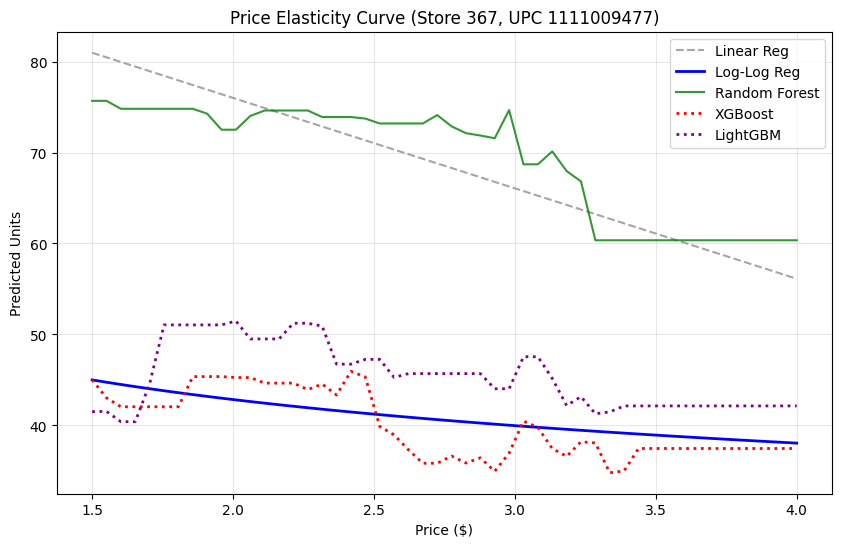

In [7]:
# Setup Synthetic Data (One Store, One UPC, varying Price)
sample_store = 367
sample_upc = 1111009477
prices = np.linspace(1.5, 4.0, 50)

curve_df = pd.DataFrame({
    'STORE_NUM': [sample_store] * len(prices),
    'UPC': [sample_upc] * len(prices),
    'PRICE': prices,
    'BASE_PRICE': prices,
    'FEATURE': 1, 'DISPLAY': 1, 'TPR_ONLY': 0, 'WEEK_NUM': 1
})

# Align OHE (Linear & RF)
curve_ohe = pd.get_dummies(curve_df, columns=['STORE_NUM', 'UPC', 'WEEK_NUM'], drop_first=True)
ohe_cols = X_ohe.columns # Define ohe_cols from the training data columns
curve_ohe = curve_ohe.reindex(columns=ohe_cols, fill_value=0)

# Align Log (Log-Log)
curve_log = curve_ohe.copy()
curve_log['PRICE'] = np.log(curve_df['PRICE'])      # Log Transform Price
curve_log['BASE_PRICE'] = np.log(curve_df['BASE_PRICE'])  # Log Transform Base Price

# Align Categorical (XGB/LGBM)
curve_cat = curve_df.copy()
# Define cat_structure from the training data for consistent categorical types
cat_structure = {
    'STORE_NUM': X_train_cat['STORE_NUM'].cat.categories,
    'UPC': X_train_cat['UPC'].cat.categories,
    'WEEK_NUM': X_train_cat['WEEK_NUM'].cat.categories
}

for col in ['STORE_NUM', 'UPC', 'WEEK_NUM']:
    curve_cat[col] = curve_cat[col].astype('category')
    #curve_cat[col] = curve_cat[col].astype(pd.CategoricalDtype(categories=cat_structure[col]))

# Get Predictions
p_lin = lr.predict(curve_ohe)
p_log = np.exp(lr_log.predict(curve_log)) # Remember to Exp()!
p_rf = rf.predict(curve_ohe)
p_xgb = xg_reg.predict(curve_cat)
p_lgbm = lgbm_reg.predict(curve_cat)

# Plot
import matplotlib.pyplot as plt # Import matplotlib
plt.figure(figsize=(10, 6))
plt.plot(prices, p_lin, label='Linear Reg', linestyle='--', color='gray', alpha=0.7)
plt.plot(prices, p_log, label='Log-Log Reg', linestyle='-', color='blue', linewidth=2)
plt.plot(prices, p_rf, label='Random Forest', linestyle='-', color='green', alpha=0.8)
plt.plot(prices, p_xgb, label='XGBoost', linestyle=':', color='red', linewidth=2)
plt.plot(prices, p_lgbm, label='LightGBM', linestyle=':', color='purple', linewidth=2)
plt.title(f'Price Elasticity Curve (Store {sample_store}, UPC {sample_upc})')
plt.xlabel('Price ($)')
plt.ylabel('Predicted Units')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Model selection and prediction for optimization

Now we will select the best model, and predict future sales for store 367 for the next week.

In [16]:
# choose LGBM as the final model and train again using the entire data (since now we know it is the best model from cross-validation)
final_model = lgb.LGBMRegressor(random_state=42)
final_model.fit(X_cat, y)


# Forecast future sales of store 367 the week following the last week in the data for the prices ranging from 1.5 to 5.5 with 0.5 increment
target_prices = np.arange(1.5, 4.0, 0.5)

# Prepare the list of UPCs
target_upcs = df['UPC'].unique()

# Now create data inputs for prediction
f_rows = []
for u in target_upcs:
    for p in target_prices:
        f_rows.append({'STORE_NUM': 367, 'UPC': u, 'PRICE': p, 'BASE_PRICE': p, 'FEATURE': 0, 'DISPLAY': 0, 'TPR_ONLY': 0, 'WEEK_NUM': 25})
        f_rows.append({'STORE_NUM': 367, 'UPC': u, 'PRICE': p, 'BASE_PRICE': p, 'FEATURE': 1, 'DISPLAY': 0, 'TPR_ONLY': 0, 'WEEK_NUM': 25})
        f_rows.append({'STORE_NUM': 367, 'UPC': u, 'PRICE': p, 'BASE_PRICE': p, 'FEATURE': 0, 'DISPLAY': 1, 'TPR_ONLY': 0, 'WEEK_NUM': 25})
        f_rows.append({'STORE_NUM': 367, 'UPC': u, 'PRICE': p, 'BASE_PRICE': p, 'FEATURE': 1, 'DISPLAY': 1, 'TPR_ONLY': 0, 'WEEK_NUM': 25})
f_df = pd.DataFrame(f_rows)

f_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 59842, number of used features: 8
[LightGBM] [Info] Start training from score 51.611978


,STORE_NUM,UPC,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,WEEK_NUM
0,367,1111009477,1.5,1.5,0,0,0,25
1,367,1111009477,1.5,1.5,1,0,0,25
2,367,1111009477,1.5,1.5,0,1,0,25
3,367,1111009477,1.5,1.5,1,1,0,25
4,367,1111009477,2.0,2.0,0,0,0,25
...,...,...,...,...,...,...,...,...
95,367,1600027564,3.0,3.0,1,1,0,25
96,367,1600027564,3.5,3.5,0,0,0,25
97,367,1600027564,3.5,3.5,1,0,0,25
98,367,1600027564,3.5,3.5,0,1,0,25


In [18]:
# repeat the same transformation process (for the category columns) and then predict the sales
f_X = f_df.copy()

# Ensure f_X has the exact same columns and order as the training data X_cat
f_X = f_X[X_cat.columns]

# Ensure categorical columns have the same categories as the training data
for col in ['STORE_NUM', 'UPC', 'WEEK_NUM']:
    f_X[col] = f_X[col].astype('category')

f_df['PREDICTED_UNITS'] = final_model.predict(f_X)

print("\nForecast Matrix (with Feature split):")
print(f_df.pivot(index=['UPC', 'FEATURE', 'DISPLAY'], columns='PRICE', values='PREDICTED_UNITS'))

f_df


Forecast Matrix (with Feature split):
PRICE                              1.5        2.0        2.5        3.0  \
UPC        FEATURE DISPLAY                                                
1111009477 0       0         15.431668  13.226651  14.600504  15.154558   
                   1         30.694916  28.489899  29.184701  27.382175   
           1       0         40.986173  40.053276  36.311101  36.766733   
                   1         59.266133  58.333236  53.912009  52.011062   
1111009497 0       0         15.507429  16.417656  17.004308  17.309153   
                   1         29.079054  29.989280  29.896881  27.845146   
           1       0         42.280940  50.347937  37.092970  38.243720   
                   1         58.869276  66.936273  53.002254  51.796424   
1600027527 0       0         22.116131  22.170946  18.174725  18.196801   
                   1         77.243477  58.085870  47.344934  39.831051   
           1       0         52.081213  41.348720  40.369228 

,STORE_NUM,UPC,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,WEEK_NUM,PREDICTED_UNITS
0,367,1111009477,1.5,1.5,0,0,0,25,15.431668
1,367,1111009477,1.5,1.5,1,0,0,25,40.986173
2,367,1111009477,1.5,1.5,0,1,0,25,30.694916
3,367,1111009477,1.5,1.5,1,1,0,25,59.266133
4,367,1111009477,2.0,2.0,0,0,0,25,13.226651
...,...,...,...,...,...,...,...,...,...
95,367,1600027564,3.0,3.0,1,1,0,25,53.228347
96,367,1600027564,3.5,3.5,0,0,0,25,15.320689
97,367,1600027564,3.5,3.5,1,0,0,25,36.248401
98,367,1600027564,3.5,3.5,0,1,0,25,30.019349


In [21]:
# Calculate the revenue for each entry
f_df['REVENUE'] = f_df['PRICE'] * f_df['PREDICTED_UNITS']

# Calculate the optimal price for each UPC and FEATURE combination that maximizes REVENUE
optimal_revenue_prices = f_df.loc[f_df.groupby(['UPC', 'FEATURE', 'DISPLAY'])['REVENUE'].idxmax()]

# Display the results
print("Optimal Prices for Maximum Weekly Revenue:")
display(optimal_revenue_prices[['UPC', 'PRICE', 'FEATURE', 'DISPLAY', 'PREDICTED_UNITS', 'REVENUE']].sort_values(['UPC', 'FEATURE']))

Optimal Prices for Maximum Weekly Revenue:


,UPC,PRICE,FEATURE,DISPLAY,PREDICTED_UNITS,REVENUE
12,1111009477,3.0,0,0,15.154558,45.463675
18,1111009477,3.5,0,1,26.102051,91.357180
17,1111009477,3.5,1,0,33.336898,116.679143
19,1111009477,3.5,1,1,50.337040,176.179640
52,1111009497,3.0,0,0,17.309153,51.927458
58,1111009497,3.5,0,1,27.115675,94.904862
57,1111009497,3.5,1,0,37.526606,131.343119
59,1111009497,3.5,1,1,52.835124,184.922933
32,1600027527,3.0,0,0,18.196801,54.590404
38,1600027527,3.5,0,1,40.224872,140.787052
